In [16]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import experiments.algo_contour_stepper as cs


# dataset_name = 'HD. Human Hair 25'

input_texture_path = '../datasets/Human Hair - HD/frame305.jpg'
glob_threshold = 2

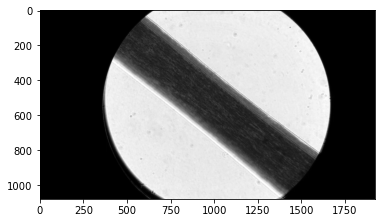

In [17]:
texture = cv.imread(input_texture_path, cv.IMREAD_COLOR)

# preprocess the texture
grayscale_texture = cv.cvtColor(texture, cv.COLOR_RGB2GRAY)
plt.imshow(grayscale_texture, cmap='gray')

In [18]:
# get the black background mask in order to afterwards transform the black background to
# be in the same cluster in Otsu's binarization as the bright one
threshold, black_background_mask = cv.threshold(grayscale_texture, glob_threshold, 255, cv.THRESH_BINARY_INV)

# find the brightest pixel - it will be used as a bright background value
minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(grayscale_texture)

# making sure that grayscaled_texture (<glob_threshold) + 255 * coeff < 255
coeff = np.min([maxVal / 255, 1 - glob_threshold / 255])

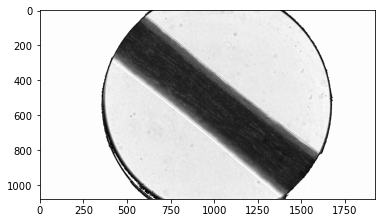

In [19]:
# adding 255 * coeff to the black background to set it bright
grayscale_texture = cv.addWeighted(grayscale_texture, 1, black_background_mask, coeff, 0)
plt.imshow(grayscale_texture, cmap='gray')

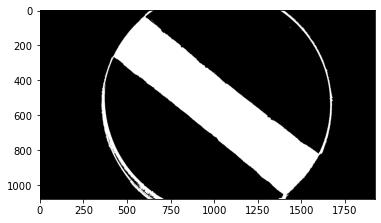

In [20]:
# apply otsu's binarization to the texture
th, mask = cv.threshold(grayscale_texture, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
plt.imshow(mask, cmap='gray')

# apply mask to the depthmap and save the result
# masked_depth_map = cv.bitwise_and(depth_map, depth_map, mask=mask)
# cv.imwrite(output_depthmap_path, masked_depth_map)

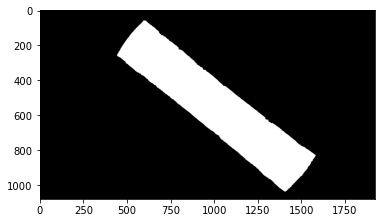

In [21]:
kernel = np.ones((5, 5), np.uint8)
erosion = cv.erode(mask, kernel, iterations=6)
plt.imshow(erosion, cmap='gray')

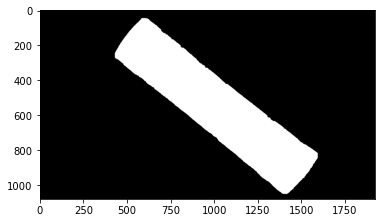

In [22]:
dilation = cv.dilate(erosion, kernel, iterations=6)
plt.imshow(dilation, cmap='gray')
mask = dilation

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

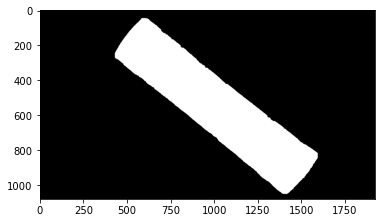

In [23]:
# also: cv2.Canny
contour = np.zeros((grayscale_texture.shape[0], grayscale_texture.shape[1]), np.uint8)
#black[:, :] = (55, 55, 55)
# не очень понимаю, как это всё работает и почему приходится делать absdiff <- это старое, сейчас всёё понимаю!
contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
plt.imshow(mask, cmap='gray')

cv.drawContours(contour, contours, -1, (255, 255, 255), 1)

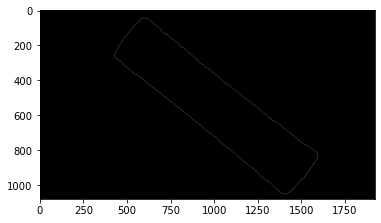

In [24]:
plt.imshow(contour, cmap='gray')

In [25]:
raw_contour = contours[0].reshape(-1, 2)
contour_mass_centre = np.mean(np.array(contours[0]), axis=0).astype(int)

In [ ]:
raw_next_contour = np.array(cs.next_contour(grayscale_texture, raw_contour, contour_mass_centre))

In [ ]:
focused_front_mask = np.zeros((grayscale_texture.shape[0], grayscale_texture.shape[1]), np.uint8)
fully_red = (np.zeros((grayscale_texture.shape[0], grayscale_texture.shape[1], 3), np.uint8) + (255, 0, 0)).astype(np.uint8)
for (x, y) in raw_next_contour:
    focused_front_mask[y, x] = 255
focused_front_mask = cv.dilate(focused_front_mask, kernel, iterations=1)
focused_front_mask_inv = cv.bitwise_not(focused_front_mask)

#img_with_focused_front_marked = cv.bitwise_or()
img_bg = cv.bitwise_and(texture, texture, mask=focused_front_mask_inv)

red_focused_front = cv.bitwise_and(fully_red, fully_red, mask=focused_front_mask)
img_with_focused_front = cv.add(img_bg, red_focused_front)
cv.imshow('lala', img_with_focused_front)
cv.waitKey(0)
cv.destroyAllWindows()
#plt.imshow(img_with_focused_front)
# plt.plot(raw_next_contour[:, 0], raw_next_contour[:, 1], '.')
# plt.plot(raw_next_contour[:, 0] + 5, raw_next_contour[:, 1] + 5, '*')
# plt.show()

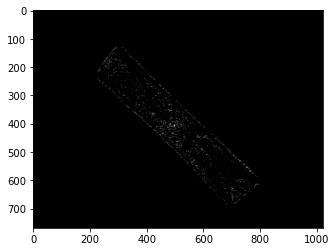

In [12]:
input_directory_path = f'../datasets/Human Hair/'
glob_threshold = 2

depthmap = np.zeros((grayscale_texture.shape[0], grayscale_texture.shape[1]), np.uint8)
for i in range(54, 85, 2):
    input_texture_path = input_directory_path + 'frame' + str(i) + '.jpg'
    texture = cv.imread(input_texture_path, cv.IMREAD_COLOR)

    # preprocess the texture
    grayscale_texture = cv.cvtColor(texture, cv.COLOR_RGB2GRAY)
    plt.imshow(grayscale_texture, cmap='gray')

    raw_next_contour = np.array(cs.next_contour(grayscale_texture, raw_contour, contour_mass_centre))
    for (point_x, point_y) in raw_next_contour:
        depthmap[point_y, point_x] = (i - 54) * 8

plt.imshow(depthmap, cmap='gray')

In [13]:
# cv.imwrite(r'..\results\depthmap.jpg', depthmap)


